In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator
from sklearn.impute import KNNImputer
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [8]:
data = pd.read_csv('./data/raw_scraped_apartment_sales_data.csv')

## *1. Initial Inspection*

In [9]:
data.shape

(2400, 18)

In [10]:
data.tail(5)

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
2395,2395,Turingevägen 41A,"Örby, Stockholms kommun",2023-10-15,1800000,1995000.0,38298,Lägenhet,1.0,47,Unknown,3 av 3,True,NaN,2549,0,Oscar Bergman,SkandiaMäklarna Älvsjö/Årsta
2396,2396,Polhemsgatan 4,"Huvudsta, Solna kommun",2023-10-15,3150000,2995000.0,56250,Lägenhet,2.0,56,Ja,3 av 4,True,1962.0,2446,6100,Fredrik Wolffelt,BOSTHLM Bromma
2397,2397,"Fyrverkarbacken 21, 13 tr",Kungsholmen,2023-10-15,11000000,11000000.0,96491,Lägenhet,5.0,114,Ja,Unknown,False,1962.0,7131,6200,Mats Uddare,Karlsson & Uddare AB
2398,2398,Sibyllegatan 14 A,"Östermalm, Stockholms kommun",2023-10-15,8400000,8250000.0,131250,Lägenhet,2.0,64,Ja,2 av 4,False,1908.0,1739,0,Daniel Levin,Behrer & Partners
2399,2399,Finnbergsvägen 62,"Finnberget, Nacka kommun",2023-10-15,2875000,2995000.0,44231,Lägenhet,2.0,65,Nej,1 av 7,True,2003.0,4087,5600,Tomas Eriksson,HusmanHagberg Nacka


## *2. Data Types and Missing Values*

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2400 non-null   int64  
 1   address                 2400 non-null   object 
 2   location                2400 non-null   object 
 3   date_sold               2400 non-null   object 
 4   price_sold_sek          2400 non-null   int64  
 5   price_listed_sek        2390 non-null   float64
 6   price_square_meter_sek  2400 non-null   int64  
 7   residence_type          2400 non-null   object 
 8   number_of_rooms         2399 non-null   float64
 9   area_size               2400 non-null   int64  
 10  balcony                 2400 non-null   object 
 11  floor_number            2400 non-null   object 
 12  elevator                2400 non-null   bool   
 13  year_built              2169 non-null   float64
 14  annual_fee_sek          2400 non-null   

In [12]:
data.isnull().sum()

Unnamed: 0                  0
address                     0
location                    0
date_sold                   0
price_sold_sek              0
price_listed_sek           10
price_square_meter_sek      0
residence_type              0
number_of_rooms             1
area_size                   0
balcony                     0
floor_number                0
elevator                    0
year_built                231
annual_fee_sek              0
annual_cost_sek             0
broker_name                 0
brokerage_firm              0
dtype: int64

## *3. Summary Statistics*

In [13]:
data.describe()

,Unnamed: 0,price_sold_sek,price_listed_sek,price_square_meter_sek,number_of_rooms,area_size,year_built,annual_fee_sek,annual_cost_sek
count,2400.000000,2.400000e+03,2.390000e+03,2400.000000,2399.000000,2400.000000,2.169000e+03,2400.000000,2400.000000
mean,1199.500000,4.044116e+06,3.961846e+06,64972.893333,2.462276,167.335000,3.310457e+05,3798.822083,4796.607083
std,692.964646,2.702155e+06,2.678311e+06,30315.311648,0.997565,242.480007,2.533883e+06,1426.993696,4537.920654
min,0.000000,4.500000e+05,5.950000e+05,10929.000000,1.000000,13.000000,1.058000e+03,0.000000,0.000000
25%,599.750000,2.300000e+06,2.295000e+06,40946.000000,2.000000,50.000000,1.939000e+03,2768.000000,0.000000
50%,1199.500000,3.250000e+06,3.150000e+06,60000.000000,2.000000,69.000000,1.965000e+03,3663.500000,4800.000000
75%,1799.250000,5.000000e+06,4.895000e+06,85965.750000,3.000000,96.000000,2.008000e+03,4718.000000,7200.000000
max,2399.000000,2.650000e+07,2.690000e+07,188764.000000,6.000000,1718.000000,2.022202e+07,10258.000000,47340.000000


In [14]:
data.nunique()

Unnamed: 0                2400
address                   2323
location                   613
date_sold                   29
price_sold_sek             708
price_listed_sek           386
price_square_meter_sek    2055
residence_type               1
number_of_rooms              6
area_size                  328
balcony                      3
floor_number               128
elevator                     2
year_built                 173
annual_fee_sek            1864
annual_cost_sek            682
broker_name               1017
brokerage_firm             305
dtype: int64

## *4. Distributions*

#### Dependent Variable

In [15]:
y = data['price_sold_sek']

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/4014155486.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


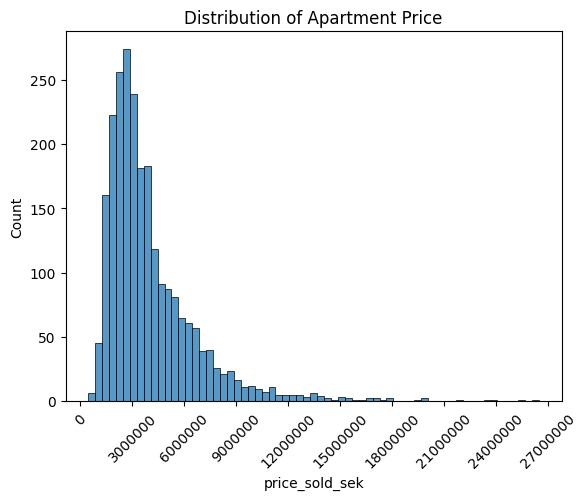

In [16]:
ax = sns.histplot(x=y)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator to set a maximum number of ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Distribution of Apartment Price')

plt.show()


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/2194558803.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


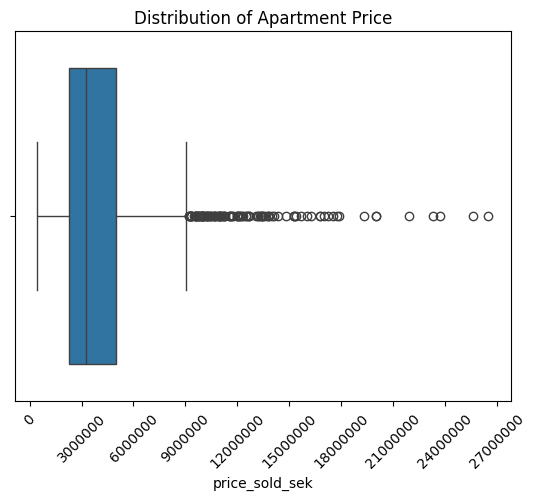

In [17]:
ax = sns.boxplot(x=y)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator if you have many unique categories in 'price_sold_sek'
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Distribution of Apartment Price')

plt.show()


Somewhat normal but right-skewed distribution of the dependent variable

#### Independent Variables

In [18]:
data.columns

Index(['Unnamed: 0', 'address', 'location', 'date_sold', 'price_sold_sek',
       'price_listed_sek', 'price_square_meter_sek', 'residence_type',
       'number_of_rooms', 'area_size', 'balcony', 'floor_number', 'elevator',
       'year_built', 'annual_fee_sek', 'annual_cost_sek', 'broker_name',
       'brokerage_firm'],
      dtype='object')

In [19]:
X = data.drop(['price_sold_sek', 'price_listed_sek', 'Unnamed: 0'], axis=1)

#### Continuous Variables

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/369603965.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


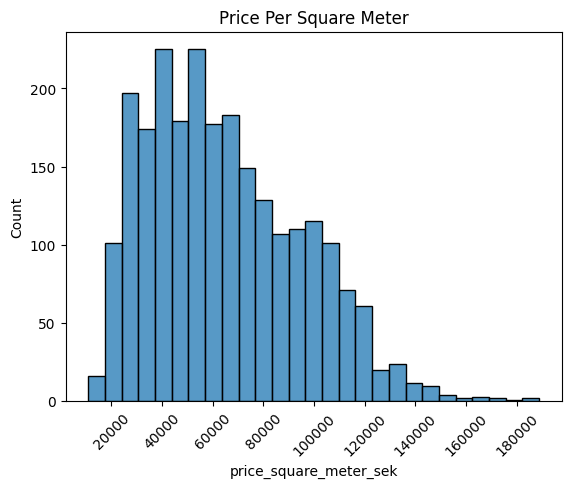

In [20]:
ax = sns.histplot(x=X['price_square_meter_sek'])

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator to set a maximum number of ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Price Per Square Meter')

plt.show()


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/4157735389.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


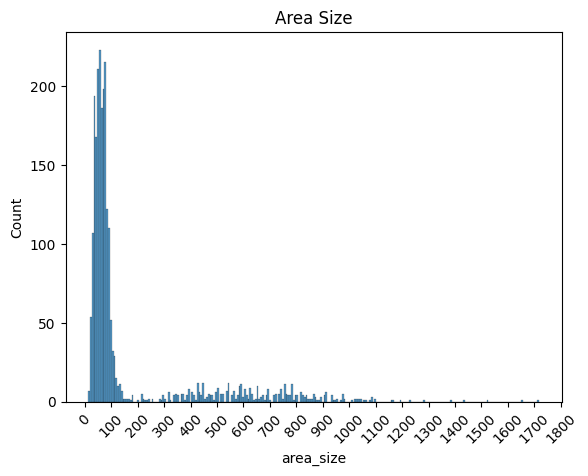

In [21]:
ax = sns.histplot(x=X['area_size'])

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator to set a maximum number of ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Area Size')

plt.show()


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/2512708007.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


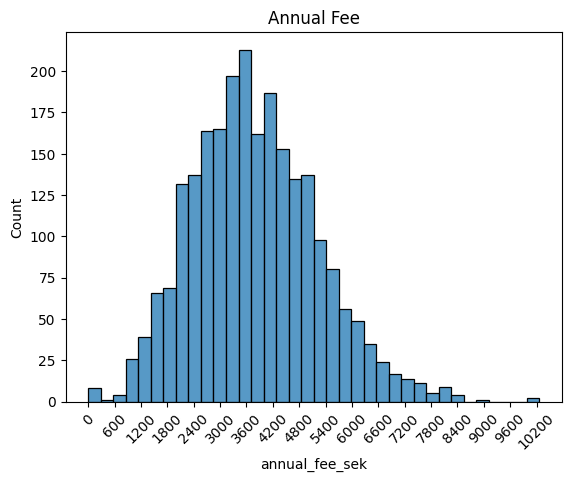

In [22]:
ax = sns.histplot(x=X['annual_fee_sek'])

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator to set a maximum number of ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Annual Fee')

plt.show()


/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/995300302.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


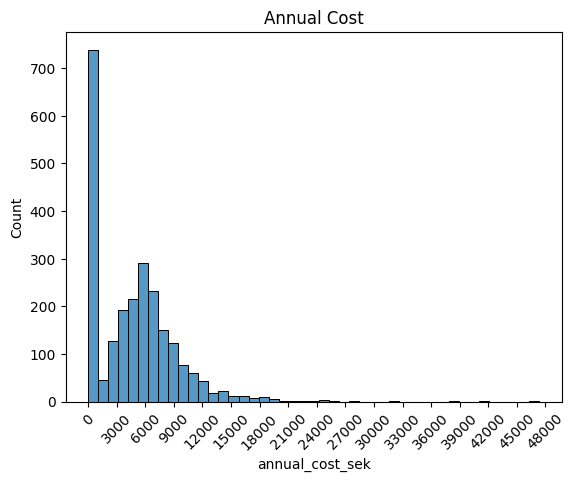

In [23]:
ax = sns.histplot(x=X['annual_cost_sek'])

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Use MaxNLocator to set a maximum number of ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))  # Adjust 'nbins' as needed

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Annual Cost')

plt.show()


#### Categorical Variables

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/659008699.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


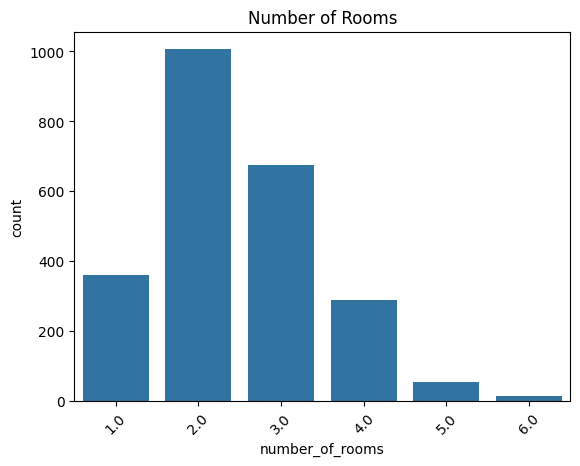

In [24]:
# Calculate the counts for each unique value in 'balcony'
counts = X['number_of_rooms'].value_counts().reset_index()
counts.columns = ['number_of_rooms', 'count']

# Create a bar plot
ax = sns.barplot(x='number_of_rooms', y='count', data=counts)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Number of Rooms')

plt.show()

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/17473117.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


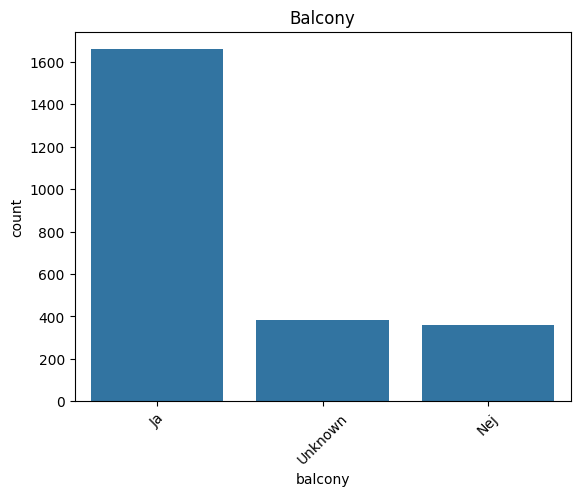

In [25]:
   # Calculate the counts for each unique value in 'balcony'
counts = X['balcony'].value_counts().reset_index()
counts.columns = ['balcony', 'count']

# Create a bar plot
ax = sns.barplot(x='balcony', y='count', data=counts)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title("Balcony")

plt.show()

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/898069678.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


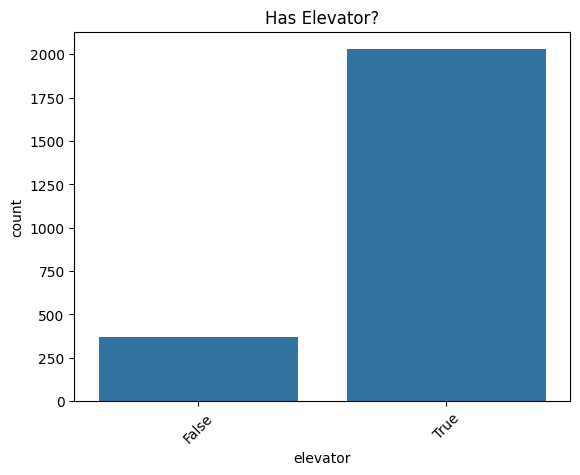

In [26]:
# Calculate the counts for each unique value in 'elevator'
counts = X['elevator'].value_counts().reset_index()
counts.columns = ['elevator', 'count']

# Create a bar plot
ax = sns.barplot(x='elevator', y='count', data=counts)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title("Has Elevator?")

plt.show()

In [27]:
# Get the counts of unique values in the 'year_built' column
year_counts = X['year_built'].value_counts()

# Select the top 10 most frequent years
top_10_years = year_counts.head(10)

# Print the top 10 years and their counts
print(top_10_years)

year_built
2018.0    62
2017.0    60
2016.0    48
1939.0    46
2019.0    46
2020.0    43
2023.0    40
1938.0    39
1960.0    36
1929.0    35
Name: count, dtype: int64


<Axes: ylabel='year_built'>

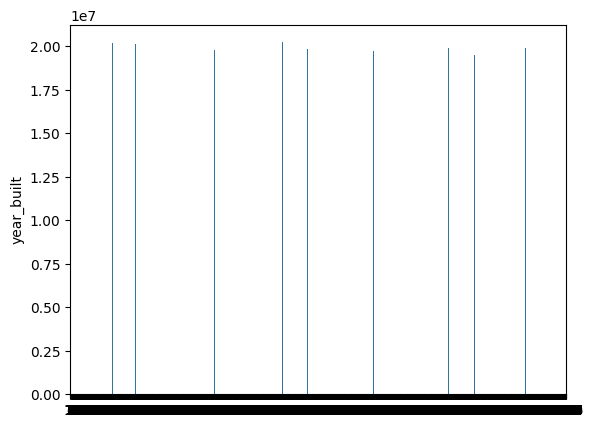

In [28]:
sns.barplot(X['year_built'])

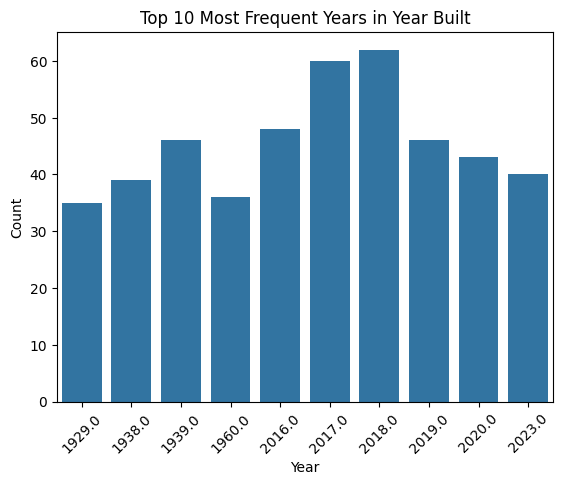

In [29]:
# Reset index to convert it into a DataFrame suitable for Seaborn
top_10_years_df = top_10_years.reset_index()
top_10_years_df.columns = ['Year', 'Count']

# Create a bar plot
sns.barplot(x='Year', y='Count', data=top_10_years_df)

# Improve plot aesthetics (optional)
plt.xticks(rotation=45)
plt.title('Top 10 Most Frequent Years in Year Built')
plt.show()

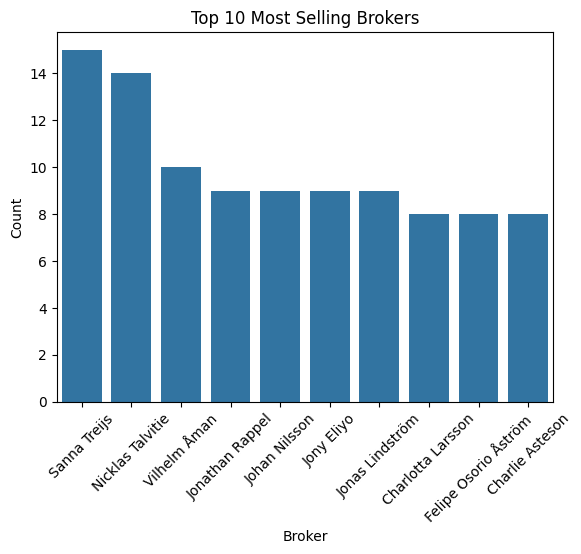

In [30]:
# Get the counts of unique values in the 'year_built' column
broker_counts = X['broker_name'].value_counts()

# Select the top 10 most frequent years
top_10_brokers = broker_counts.head(10)

# Reset index to convert it into a DataFrame suitable for Seaborn
top_10_brokers = top_10_brokers.reset_index()
top_10_brokers.columns = ['Broker', 'Count']

# Create a bar plot
sns.barplot(x='Broker', y='Count', data=top_10_brokers)

# Improve plot aesthetics (optional)
plt.xticks(rotation=45)
plt.title('Top 10 Most Selling Brokers')
plt.show()

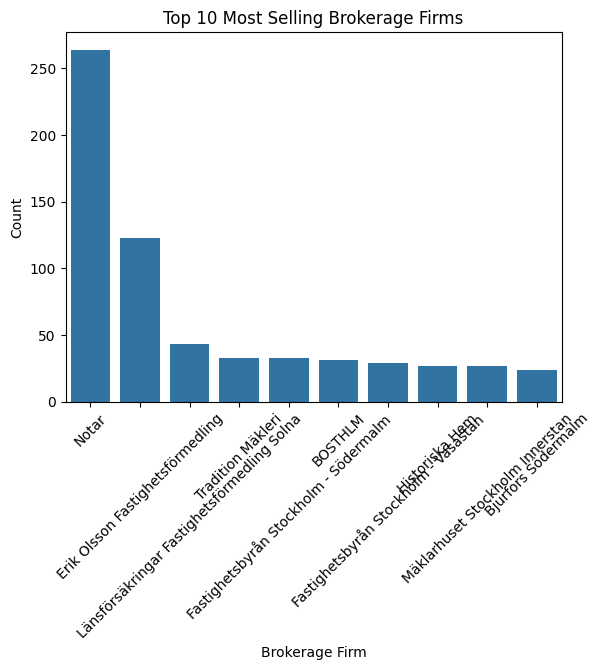

In [31]:
# Get the counts of unique values in the 'year_built' column
brokerage_firm_counts = X['brokerage_firm'].value_counts()

# Select the top 10 most frequent years
top_10_firms = brokerage_firm_counts.head(10)

# Reset index to convert it into a DataFrame suitable for Seaborn
top_10_firms = top_10_firms.reset_index()
top_10_firms.columns = ['Brokerage Firm', 'Count']

# Create a bar plot
sns.barplot(x='Brokerage Firm', y='Count', data=top_10_firms)

# Improve plot aesthetics (optional)
plt.xticks(rotation=45)
plt.title('Top 10 Most Selling Brokerage Firms')
plt.show()

In [32]:
print(top_10_firms)

                                Brokerage Firm  Count
0                                        Notar    264
1             Erik Olsson Fastighetsförmedling    123
2  Länsförsäkringar Fastighetsförmedling Solna     43
3                            Tradition Mäkleri     33
4        Fastighetsbyrån Stockholm - Södermalm     33
5                                      BOSTHLM     31
6         Fastighetsbyrån Stockholm - Vasastan     29
7                               Historiska Hem     27
8              Mäklarhuset Stockholm Innerstan     27
9                           Bjurfors Södermalm     24


In [33]:
X['brokerage_firm'].nunique()

305

/var/folders/t_/0sss_n354p10j1d1j41c4ml00000gn/T/ipykernel_21432/898069678.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


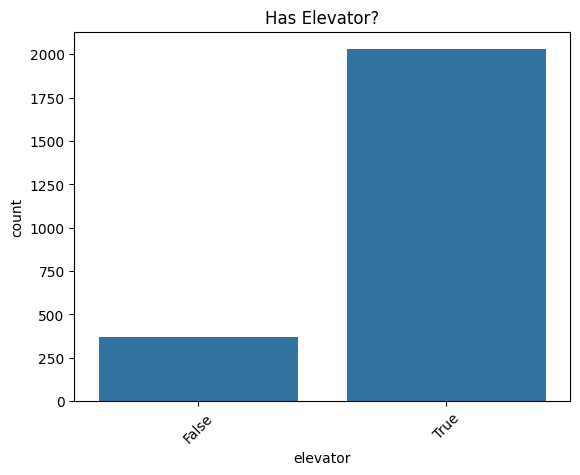

In [34]:
# Calculate the counts for each unique value in 'elevator'
counts = X['elevator'].value_counts().reset_index()
counts.columns = ['elevator', 'count']

# Create a bar plot
ax = sns.barplot(x='elevator', y='count', data=counts)

# Set tick format to plain to avoid scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Optionally, rotate labels for readability
# Only set tick labels after setting the locator
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title("Has Elevator?")

plt.show()

#### Summary: Distributions

??

## *Outliers*

In [35]:
def calculate_outliers_iqr(df, column_str):
  # 1.5 iqr rule

  pct25 = df[column_str].quantile(0.25)
  pct75 = df[column_str].quantile(0.75)
  iqr = pct75 - pct25

  outlier_upper = pct75 + (iqr * 1.5)
  outlier_lower = pct25 - (iqr * 1.5)

  cond = (df[column_str] > outlier_upper) | (df[column_str] < outlier_lower)

  outliers_iqr = df[cond]
  #print(len(outliers_iqr))
  return outliers_iqr

In [36]:
def calculate_outliers_z(df, column_str):
  # z-score method 
  # z = (x-U)/Ox

  # Assuming data is a pandas DataFrame and you're interested in the 'price_sold_sek' column
  mean = df[column_str].mean()
  std_dev = df[column_str].std()

  # Filter outliers based on Z-score without adding a new column
  outliers_z = df[((df[column_str] - mean) / std_dev > 3) | 
                  ((df[column_str] - mean) / std_dev < -3)]

  #print(len(outliers_z))
  return outliers_z

In [37]:
numerical_dimensions = data.select_dtypes(['float64', 'int64'])

numerical_dimensions

,Unnamed: 0,price_sold_sek,price_listed_sek,price_square_meter_sek,number_of_rooms,area_size,year_built,annual_fee_sek,annual_cost_sek
0,0,4400000,4200000.0,59459,3.0,74,1953.0,4899,9000
1,1,1015000,1095000.0,40600,1.0,25,1961.0,2265,3120
2,2,7450000,7450000.0,102759,3.0,725,2023.0,4428,0
3,3,1395000,1495000.0,34875,1.0,40,1955.0,3250,4500
4,4,3150000,2795000.0,101613,1.0,31,1963.0,1290,6804
...,...,...,...,...,...,...,...,...,...
2395,2395,1800000,1995000.0,38298,1.0,47,NaN,2549,0
2396,2396,3150000,2995000.0,56250,2.0,56,1962.0,2446,6100
2397,2397,11000000,11000000.0,96491,5.0,114,1962.0,7131,6200
2398,2398,8400000,8250000.0,131250,2.0,64,1908.0,1739,0


#### Price Sold

In [38]:
iqr_outliers = calculate_outliers_iqr(data, 'price_sold_sek')
z_outliers = calculate_outliers_z(data, 'price_sold_sek')

In [39]:
combined_outliers = z_outliers.merge(iqr_outliers, how='inner')

In [40]:
len(combined_outliers)

45

In [41]:
combined_outliers.head()

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
0,69,Hammarby allé 55B,Södermalm,2023-11-10,13800000,16000000.0,99281,Lägenhet,4.0,139,Ja,6 av 6,True,2014.0,7529,25059,Andreas Nylén,Tradition Mäkleri
1,80,Kungsgatan 77,Kungsholmen,2023-11-10,17750000,21000000.0,116546,Lägenhet,5.0,1523,Ja,5 av 5,True,1906.0,6425,41316,Patrik Lundberg,Widerlöv Kungsholmen
2,112,Drottninggatan 112,"Vasastan/Norrmalm, Stockholms kommun",2023-11-10,14350000,15995000.0,113889,Lägenhet,4.0,126,Ja,5 av 5,True,1861.0,4179,10500,Niklas Wellmér,Erik Olsson Fastighetsförmedling
3,114,Nybrogatan 42A,"Östermalm, Stockholms kommun",2023-11-10,23700000,23000000.0,170504,Lägenhet,4.0,139,Ja,3,True,1882.0,3063,8900,Gustav Enhörning,SJÖMAN\FRISK
4,251,Östermalmsgatan 75,"Östermalm, Stockholms kommun",2023-11-09,17900000,18600000.0,123448,Lägenhet,4.0,145,Ja,2 av 5,True,1897.0,7541,18000,Anita Ek,Ek & Co Fastighetsförmedling AB


<Axes: ylabel='price_sold_sek'>

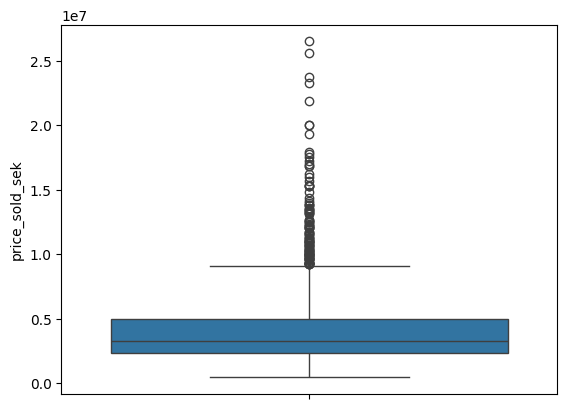

In [42]:
sns.boxplot(data['price_sold_sek'])

#### Price Square Meter

In [43]:
iqr_outliers = calculate_outliers_iqr(data, 'price_square_meter_sek')
z_outliers = calculate_outliers_z(data, 'price_square_meter_sek')
combined_outliers = z_outliers.merge(iqr_outliers, how='inner')

In [44]:
len(combined_outliers)

10

In [45]:
combined_outliers.head(5)

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
0,114,Nybrogatan 42A,"Östermalm, Stockholms kommun",2023-11-10,23700000,23000000.0,170504,Lägenhet,4.0,139,Ja,3,True,1882.0,3063,8900,Gustav Enhörning,SJÖMAN\FRISK
1,365,"Valhallavägen 134, 6 tr",Östermalm,2023-11-08,16000000,15500000.0,179775,Lägenhet,4.0,89,Ja,6 av 6,True,1924.0,5115,0,Magnus Larsson,Tradition Mäkleri
2,390,Styrmansgatan 47,"Östermalm, Stockholms kommun",2023-11-08,11100000,9995000.0,165672,Lägenhet,3.0,67,Ja,Unknown,False,NaN,4139,0,Johanna Nydén,Lagerlings
3,772,Renstiernas gata 20,Södermalm,2023-11-02,8500000,8750000.0,166667,Lägenhet,2.0,51,Nej,Unknown,False,1911.0,3928,18833,Charlotte Pellas,Historiska Hem
4,1086,Floragatan 17 A,"Östermalm, Stockholms kommun",2023-10-30,12250000,12000000.0,157051,Lägenhet,3.0,78,Ja,2 av 4,True,1885.0,3664,7000,Erik Frisk,SJÖMAN\FRISK


<Axes: xlabel='price_square_meter_sek', ylabel='price_sold_sek'>

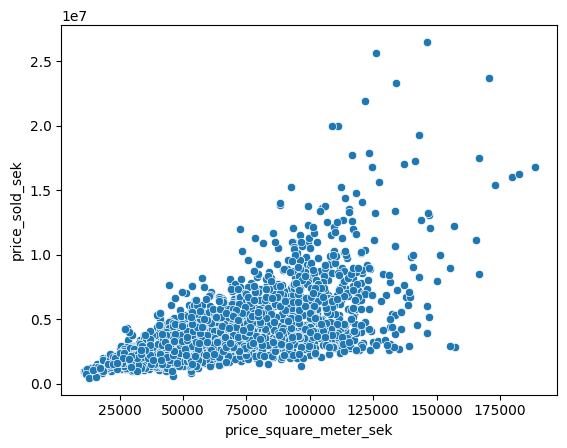

In [46]:
sns.scatterplot(x='price_square_meter_sek', y='price_sold_sek', data=data)

#### Area Size

In [47]:
iqr_outliers = calculate_outliers_iqr(data, 'area_size')
z_outliers = calculate_outliers_z(data, 'area_size')
combined_outliers = z_outliers.merge(iqr_outliers, how='inner')

In [48]:
len(combined_outliers)

55

In [49]:
combined_outliers.head(5)

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
0,7,Kavallerivägen 20,"Rissne, Sundbybergs kommun",2023-11-11,3280000,3295000.0,35080,Lägenhet,4.0,935,Ja,7 av 9,True,2004.0,5540,0,Gabriel Mirza,HusmanHagberg Sundbyberg
1,10,Skidbacksvägen 6,Saltsjöbaden,2023-11-11,6550000,6450000.0,70053,Lägenhet,3.0,935,Ja,4 av 4,True,2002.0,6406,0,Henrik Silver,Bjurfors Nacka
2,64,Parkvägen 9,"Järfälla Barkarbystaden, Järfälla kommun",2023-11-10,3395000,3595000.0,37104,Lägenhet,3.0,915,Nej,1 av 5,True,2015.0,5249,8268,Günay Coksürer,Notar
3,80,Kungsgatan 77,Kungsholmen,2023-11-10,17750000,21000000.0,116546,Lägenhet,5.0,1523,Ja,5 av 5,True,1906.0,6425,41316,Patrik Lundberg,Widerlöv Kungsholmen
4,236,Bergshöjden 40,"Hallonbergen, Sundbybergs kommun",2023-11-09,3350000,3495000.0,28128,Lägenhet,5.0,1191,Nej,Unknown,False,1972.0,7482,2500,Andreas Yacoub,Mäklarringen Vällingby/Hässelby


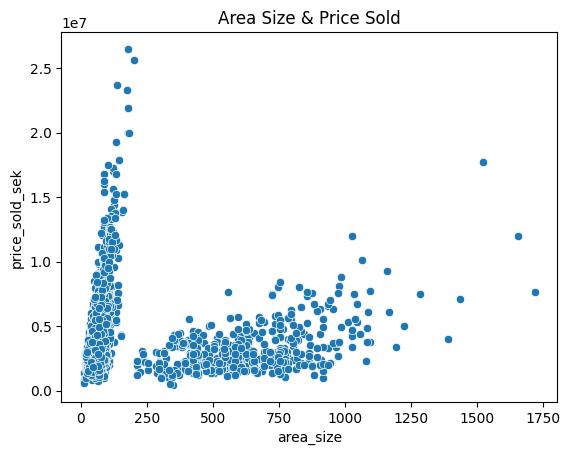

In [50]:
sns.scatterplot(x='area_size', y='price_sold_sek', data=data)
plt.title('Area Size & Price Sold')

plt.show()

#### Annual Fee

In [51]:
iqr_outliers = calculate_outliers_iqr(data, 'annual_fee_sek')
z_outliers = calculate_outliers_z(data, 'annual_fee_sek')
combined_outliers = z_outliers.merge(iqr_outliers, how='inner')

In [52]:
len(combined_outliers)

13

In [53]:
combined_outliers.head(5)

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
0,63,Terapivägen 10C,"Flemingsberg, Huddinge kommun",2023-11-10,1270000,1195000.0,15301,Lägenhet,3.0,83,Ja,11 av 11,True,1975.0,8366,4884,Mithat Bircan,Notar
1,486,"Skarpbrunnavägen 19, 7tr+8tr",Botkyrka,2023-11-06,1000000,1595000.0,10929,Lägenhet,3.0,915,Ja,7,True,NaN,8173,0,Aram Soma,Fastighetsbyrån Norra Botkyrka
2,577,Centralvägen 14 A,"Centrum, Vallentuna kommun",2023-11-04,3750000,3995000.0,30000,Lägenhet,5.0,125,Unknown,1 av 5,True,2022.0,8426,3400,Erik Laggar,Fastighetsbyrån Vallentuna
3,598,"Ynglingagatan 17, 4tr","Vasastan, Stockholms kommun",2023-11-04,15250000,15500000.0,92424,Lägenhet,3.0,165,Ja,4 av 5,True,NaN,8209,7200,Tina Engström,Bjurfors Vasastan
4,600,"Ynglingagatan 17, 4tr","Vasastan, Stockholms kommun",2023-11-04,15250000,15500000.0,92424,Lägenhet,3.0,165,Ja,4 av 5,True,NaN,8209,7200,Tina Engström,Bjurfors Vasastan


Text(0.5, 1.0, 'Price Sold & Annual Fee')

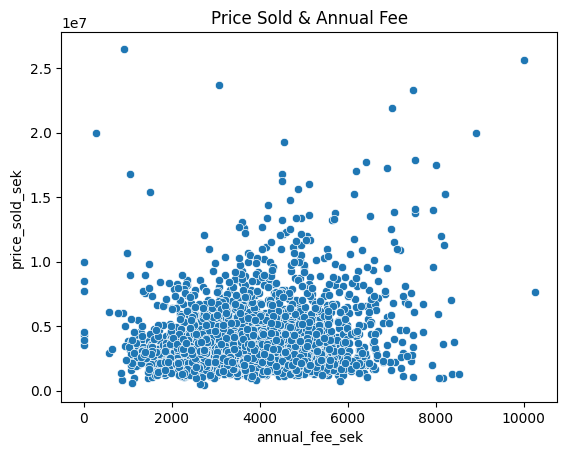

In [54]:
sns.scatterplot(x='annual_fee_sek', y='price_sold_sek', data=data)
plt.title('Price Sold & Annual Fee')

#### Annual Cost

In [55]:
iqr_outliers = calculate_outliers_iqr(data, 'annual_cost_sek')
z_outliers = calculate_outliers_z(data, 'annual_cost_sek')
combined_outliers = z_outliers.merge(iqr_outliers, how='inner')

In [56]:
len(combined_outliers)

27

In [57]:
combined_outliers.head(5)

,Unnamed: 0,address,location,date_sold,price_sold_sek,price_listed_sek,price_square_meter_sek,residence_type,number_of_rooms,area_size,balcony,floor_number,elevator,year_built,annual_fee_sek,annual_cost_sek,broker_name,brokerage_firm
0,69,Hammarby allé 55B,Södermalm,2023-11-10,13800000,16000000.0,99281,Lägenhet,4.0,139,Ja,6 av 6,True,2014.0,7529,25059,Andreas Nylén,Tradition Mäkleri
1,80,Kungsgatan 77,Kungsholmen,2023-11-10,17750000,21000000.0,116546,Lägenhet,5.0,1523,Ja,5 av 5,True,1906.0,6425,41316,Patrik Lundberg,Widerlöv Kungsholmen
2,100,Textilgatan 21,"Hammarby Sjöstad, Stockholms kommun",2023-11-10,5200000,4995000.0,76471,Lägenhet,3.0,68,Ja,3 av 5,True,2014.0,3690,18480,Raymond Lindeborg,Svensk Fastighetsförmedling Hammarby Sjöstad
3,167,Samaritgränd 3,"Södermalm Maria, Stockholms kommun",2023-11-09,7600000,6950000.0,101333,Lägenhet,3.0,75,Nej,0,True,1929.0,4312,19752,Caroline Klasson,Bjurfors Södermalm
4,324,Gransätragränd 9,"Sätra, Stockholms kommun",2023-11-08,2940000,2895000.0,31277,Lägenhet,4.0,94,Ja,1 av 2,True,1963.0,5858,19438,Enkidu Afram,Fastighetsbyrån Hägersten/Älvsjö


Text(0.5, 1.0, 'Price Sold & Annual Cost')

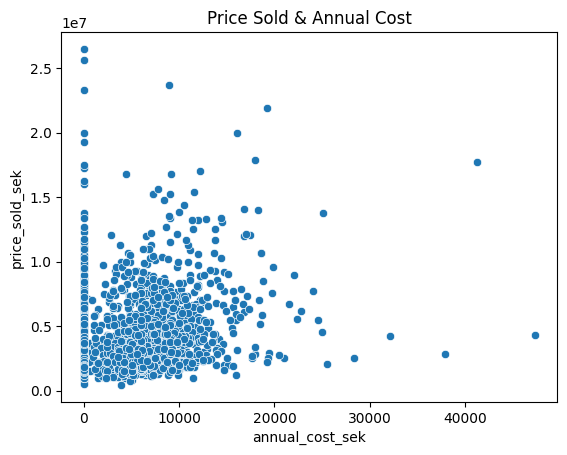

In [58]:
sns.scatterplot(x='annual_cost_sek', y='price_sold_sek', data=data)
plt.title('Price Sold & Annual Cost')

#### Summary: Outliers
Nearly all the price-related outliers seem to be located in very central areas such as Östermalm, Kungsholmen, and Södermalm. Thus, they're not really outliers but just a function of their location and size.